# 1. 生データを読み込む（例：raw_data = pd.read_csv()）
# 2. SageMaker上で使用する列のみのテーブルを作成する
# 3. 生データをメモリ上から削除する
# 　 pythonコード：del raw_data（生データのテーブル名）で削除できます
# 4. gc.collect()を実行
# 　※import gc必要
# 5. ヒストグラム等を書く


# processor_unit_units_hardware_info_serial_number_cpu_bdの始め3つの数字と
# ADPの対応は以下の通りです。
 
# ・017以上　→　ADP556（新しい方）
# ・017未満　→　ADP555

In [1]:
!pip install dfply


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import sys
import pandas as pd
import numpy as np
from sklearn import svm
import scipy.stats
import matplotlib.pyplot as plt
import csv
import re
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
from sklearn import preprocessing
import datetime
from dfply import *
import random
import gc
plt.style.use('ggplot')

## データ読み込み

In [4]:
raw_data_ECDIS = pd.read_csv('../ECDIS__FMD-3x00.csv', header=0, delimiter=',',dtype = {"equipment_label_no":"object","f_shipno":"object"})

raw_data_ECDIS = raw_data_ECDIS >> mutate(id = X.f_shipno+"-"+X.equipment_label_no,
                         measurement_ymd = X.measurement_date.str[:10],
                         measurement_ymd_h = X.measurement_date.str[11:13]) >> mutate(
    measurement_ymd_hms = X.measurement_ymd+" "+X.measurement_ymd_h+":00:00")

FileNotFoundError: [Errno 2] No such file or directory: '../ECDIS__FMD-3x00.csv'

In [ ]:
raw_data_Radar= pd.read_csv('../Radar__FAR-3xx0.csv', header=0, delimiter=',',dtype = {"equipment_label_no":"object","f_shipno":"object"})
raw_data_Radar = raw_data_Radar>> mutate(id = X.f_shipno+"-"+X.equipment_label_no,
                         measurement_ymd = X.measurement_date.str[:10],
                         measurement_ymd_h = X.measurement_date.str[11:13]) >> mutate(
    measurement_ymd_hms = X.measurement_ymd+" "+X.measurement_ymd_h+":00:00")

C:\Users\IORIOKI\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (57,58,59,60,61,62,63,64,65,66,70,71,72,73,74,75,76,77,78,79,99,101,105,171,173,174,175,176,179,180,198,199,202,244,245,246,247,249,250,251,255,256,257,258,259,260,264,265,266,267,268,269) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
raw_data_ECDIS.head(5)

,equipment_label_no,f_shipno,imono,shipnameen,monitored_equipment_category_name,monitored_equipment_model_name,measurement_date,service_gateway_date,system_date_time,list_version,...,rcu3_units_status_main__timer_int_sta,rcu3_units__unit,rcu3_units__unit_name,rcu3_units__unit_type,created_at,is_hermace_data,id,measurement_ymd,measurement_ymd_h,measurement_ymd_hms
0,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-03 07:54:06,2020-06-03 07:54:06,2020-06-03 07:56:40,1,...,NaN,NaN,NaN,NaN,2020-06-03 08:01:24,f,9883118-4533,2020-06-03,07,2020-06-03 07:00:00
1,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-03 08:00:01,2020-06-03 08:00:01,2020-06-03 08:02:36,1,...,NaN,NaN,NaN,NaN,2020-06-03 08:11:22,f,9883118-4533,2020-06-03,08,2020-06-03 08:00:00
2,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-03 09:00:02,2020-06-03 09:00:02,2020-06-03 09:02:36,1,...,NaN,NaN,NaN,NaN,2020-06-03 09:08:51,f,9883118-4533,2020-06-03,09,2020-06-03 09:00:00
3,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-04 01:00:01,2020-06-04 01:00:01,2020-06-04 01:02:37,1,...,NaN,NaN,NaN,NaN,2020-06-04 15:39:03,f,9883118-4533,2020-06-04,01,2020-06-04 01:00:00
4,4533,9883118,9883118.0,AFRICAN PARROT,ECDIS,FMD-3x00,2020-06-04 02:00:01,2020-06-04 02:00:01,2020-06-04 02:02:37,1,...,NaN,NaN,NaN,NaN,2020-06-04 02:08:51,f,9883118-4533,2020-06-04,02,2020-06-04 02:00:00


In [ ]:
raw_data_Radar.head(5)

,equipment_label_no,f_shipno,imono,shipnameen,monitored_equipment_category_name,monitored_equipment_model_name,measurement_date,service_gateway_date,is_xml_data_format,processor_unit_units_status_boot_device_model_name,...,rsb_units_parent_name,rsb_units_status_main_mtr_dipsw,rsb_units_status_main_pm_dipsw,rsb_units_status_main_rfc_dipsw,created_at,is_hermace_data,id,measurement_ymd,measurement_ymd_h,measurement_ymd_hms
0,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-23 07:00:02,2020-12-23 07:00:02,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-23 07:05:20,f,9863558-7073,2020-12-23,07,2020-12-23 07:00:00
1,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-23 08:00:01,2020-12-23 08:00:01,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-23 08:05:36,f,9863558-7073,2020-12-23,08,2020-12-23 08:00:00
2,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-23 09:00:01,2020-12-23 09:00:01,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-23 09:05:36,f,9863558-7073,2020-12-23,09,2020-12-23 09:00:00
3,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-25 04:00:02,2020-12-25 04:00:02,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-25 04:08:14,f,9863558-7073,2020-12-25,04,2020-12-25 04:00:00
4,7073,9863558,9863558.0,ALTERA WAVE,Radar,FAR-3xx0,2020-12-25 05:00:01,2020-12-25 05:00:01,f,CAG3B04GVDBWSZ-F,...,PROCESSOR_UNIT,NaN,NaN,NaN,2020-12-25 05:08:10,f,9863558-7073,2020-12-25,05,2020-12-25 05:00:00


In [ ]:
raw_data_ECDIS_select = raw_data_ECDIS[["id","equipment_label_no","f_shipno","measurement_date"
                                        ,"processor_unit_units_hardware_info__serial_number_cpu_bd","monitor1_units__unit","monitor2_units__unit"
                                        ,"measurement_ymd","measurement_ymd_h","measurement_ymd_hms"
                                        ,"monitor1_units_status_main__temp","monitor1_units_status_main__fan1"
                                        ,"monitor1_units_status_main__fan2","monitor1_units_status_main__fan3"
                                        ,"monitor2_units_status_main__temp","monitor2_units_status_main__fan1"
                                        ,"monitor2_units_status_main__fan2","monitor2_units_status_main__fan3","processor_unit_units_status_cpu_board__cpu_fan"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_temp","processor_unit_units_status_cpu_board__cpu_core_temp"
                                        ,"processor_unit_units_status_cpu_board__gpu_core_temp","processor_unit_units_status_cpu_board__remote1_temp"
                                        ,"processor_unit_units_status_cpu_board__remote2_temp","processor_unit_units_status_cpu_board__cpu_core_vol"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_vbat","processor_unit_units_status_cpu_board__cpu_bd_p3_3v"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_p5v","processor_unit_units_status_cpu_board__cpu_bd_p12v"
                                        ,"processor_unit_units_status_cpu_board__cpu_bd_fan1","processor_unit_units_status_cpu_board__cpu_bd_fan2"
                                        ,"processor_unit_units_status_boot_device__wearout_ind"]]

raw_data_ECDIS_select.head(5)

,id,equipment_label_no,f_shipno,measurement_date,processor_unit_units_hardware_info__serial_number_cpu_bd,monitor1_units__unit,monitor2_units__unit,measurement_ymd,measurement_ymd_h,measurement_ymd_hms,...,processor_unit_units_status_cpu_board__remote1_temp,processor_unit_units_status_cpu_board__remote2_temp,processor_unit_units_status_cpu_board__cpu_core_vol,processor_unit_units_status_cpu_board__cpu_bd_vbat,processor_unit_units_status_cpu_board__cpu_bd_p3_3v,processor_unit_units_status_cpu_board__cpu_bd_p5v,processor_unit_units_status_cpu_board__cpu_bd_p12v,processor_unit_units_status_cpu_board__cpu_bd_fan1,processor_unit_units_status_cpu_board__cpu_bd_fan2,processor_unit_units_status_boot_device__wearout_ind
0,9883118-4533,4533,9883118,2020-06-03 07:54:06,O19H6555,MU-270W,NaN,2020-06-03,07,2020-06-03 07:00:00,...,43.0,43.0,0.844,3.698,3.317,5.104,12.063,4663.0,4627.0,1.0
1,9883118-4533,4533,9883118,2020-06-03 08:00:01,O19H6555,MU-270W,NaN,2020-06-03,08,2020-06-03 08:00:00,...,43.0,43.0,0.844,3.698,3.317,5.104,12.063,4659.0,4623.0,1.0
2,9883118-4533,4533,9883118,2020-06-03 09:00:02,O19H6555,MU-270W,NaN,2020-06-03,09,2020-06-03 09:00:00,...,44.0,44.0,0.844,3.698,3.317,5.104,12.063,4639.0,4639.0,1.0
3,9883118-4533,4533,9883118,2020-06-04 01:00:01,O19H6555,MU-270W,NaN,2020-06-04,01,2020-06-04 01:00:00,...,41.0,41.0,0.855,3.698,3.317,5.104,12.063,4667.0,4615.0,1.0
4,9883118-4533,4533,9883118,2020-06-04 02:00:01,O19H6555,MU-270W,NaN,2020-06-04,02,2020-06-04 02:00:00,...,45.0,45.0,0.844,3.698,3.317,5.104,12.063,4639.0,4659.0,1.0


In [ ]:
data_ECDIS=raw_data_ECDIS_select.rename(columns={"processor_unit_units_hardware_info__serial_number_cpu_bd":"processor_unit_units_hardware_info_serial_number_cpu_bd"
                                                 ,"monitor1_units__unit":"monitor1_units_unit"
                                                 ,"monitor2_units__unit":"monitor2_units_unit"
                                                 ,"monitor1_units_status_main__temp":"monitor1_units_status_main_temp"
                                                 ,"monitor1_units_status_main__fan1":"monitor1_units_status_main_fan1"
                                                 ,"monitor1_units_status_main__fan2":"monitor1_units_status_main_fan2"
                                                 ,"monitor1_units_status_main__fan3":"monitor1_units_status_main_fan3"
                                                 ,"monitor2_units_status_main__temp":"monitor2_units_status_main_temp"
                                                 ,"monitor2_units_status_main__fan1":"monitor2_units_status_main_fan1"
                                                 ,"monitor2_units_status_main__fan2":"monitor2_units_status_main_fan2"
                                                 ,"monitor2_units_status_main__fan3":"monitor2_units_status_main_fan3"
                                                 ,"processor_unit_units_status_cpu_board__cpu_fan":"processor_unit_units_status_cpu_board_cpu_fan"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_temp":"processor_unit_units_status_cpu_board_cpu_bd_temp"
                                                 ,"processor_unit_units_status_cpu_board__cpu_core_temp":"processor_unit_units_status_cpu_board_cpu_core_temp"
                                                 ,"processor_unit_units_status_cpu_board__gpu_core_temp":"processor_unit_units_status_cpu_board_gpu_core_temp"
                                                 ,"processor_unit_units_status_cpu_board__remote1_temp":"processor_unit_units_status_cpu_board_remote1_temp"
                                                 ,"processor_unit_units_status_cpu_board__remote2_temp":"processor_unit_units_status_cpu_board_remote2_temp"
                                                 ,"processor_unit_units_status_cpu_board__cpu_core_vol":"processor_unit_units_status_cpu_board_cpu_core_vol"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_vbat":"processor_unit_units_status_cpu_board_cpu_bd_vbat"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p3_3v":"processor_unit_units_status_cpu_board_cpu_bd_p3_3v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p5v":"processor_unit_units_status_cpu_board_cpu_bd_p5v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_p12v":"processor_unit_units_status_cpu_board_cpu_bd_p12v"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_fan1":"processor_unit_units_status_cpu_board_cpu_bd_fan1"
                                                 ,"processor_unit_units_status_cpu_board__cpu_bd_fan2":"processor_unit_units_status_cpu_board_cpu_bd_fan2"
                                                 ,"processor_unit_units_status_boot_device__wearout_ind":"processor_unit_units_status_boot_device_wearout_ind"
                                                })

In [ ]:
data_Radar = raw_data_Radar[["id","equipment_label_no","f_shipno","measurement_date",
                             "processor_unit_units_hardware_info_serial_number_cpu_bd","monitor1_units_unit","monitor2_units_unit",
                             "measurement_ymd","measurement_ymd_h","measurement_ymd_hms",
                             "monitor1_units_status_main_temp","monitor1_units_status_main_fan1",
                            "monitor1_units_status_main_fan2","monitor1_units_status_main_fan3"
                             ,"monitor2_units_status_main_temp"
                             ,"monitor2_units_status_main_fan1","monitor2_units_status_main_fan2"
                             ,"monitor2_units_status_main_fan3","processor_unit_units_status_cpu_board_cpu_fan",
                            "processor_unit_units_status_cpu_board_cpu_bd_temp","processor_unit_units_status_cpu_board_cpu_core_temp",
                            "processor_unit_units_status_cpu_board_gpu_core_temp","processor_unit_units_status_cpu_board_remote1_temp",
                            "processor_unit_units_status_cpu_board_remote2_temp","processor_unit_units_status_cpu_board_cpu_core_vol",
                            "processor_unit_units_status_cpu_board_cpu_bd_vbat","processor_unit_units_status_cpu_board_cpu_bd_p3_3v",
                            "processor_unit_units_status_cpu_board_cpu_bd_p5v","processor_unit_units_status_cpu_board_cpu_bd_p12v",
                            "processor_unit_units_status_cpu_board_cpu_bd_fan1","processor_unit_units_status_cpu_board_cpu_bd_fan2",
                            "processor_unit_units_status_storage_device_wearout_ind"]]

## 結合

In [ ]:
con=pd.concat([data_Radar, data_ECDIS])
data_con=con

In [ ]:
del raw_data_ECDIS
del raw_data_Radar

In [ ]:
gc.collect()

100

In [ ]:
print("ECDIS&Radar")
print("f_shipnoユニーク数          :",data_con["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_con["equipment_label_no"].unique()),"\n")

print("ECDIS")
print("f_shipnoユニーク数          :",data_ECDIS["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_ECDIS["equipment_label_no"].unique()),"\n")

print("Radar")
print("f_shipnoユニーク数          :",data_Radar["f_shipno"].nunique())
print("equipment_label_noユニーク数:",len(data_Radar["equipment_label_no"].unique()),"\n")

ECDIS&Radar
f_shipnoユニーク数          : 114
equipment_label_noユニーク数: 367 

ECDIS
f_shipnoユニーク数          : 112
equipment_label_noユニーク数: 271 

Radar
f_shipnoユニーク数          : 46
equipment_label_noユニーク数: 96 



In [ ]:
# raw_data.shape
print("行数: "+str(data_con.shape[0]))
print("列数: "+str(data_con.shape[1]))
#データ期間
print("データ開始日時: "+str(data_con["measurement_date"].min()))
print("データ終了日時: "+str(data_con["measurement_date"].max()))
print("f_shipno(ユニーク数): "+str(data_con["f_shipno"].nunique()))
print("equipment_label_no(ユニーク数): "+str(data_con["equipment_label_no"].nunique()))

行数: 2339341
列数: 33
データ開始日時: 2014-10-10 09:00:01
データ終了日時: 2021-04-20 23:34:16
f_shipno(ユニーク数): 114
equipment_label_no(ユニーク数): 367


In [ ]:
data_con["monitor1_units_unit"].value_counts()

MU-270W       1496949
MU-231         577455
HD26T21MMD     186805
MU-190          55612
Name: monitor1_units_unit, dtype: int64

In [ ]:
data_con["measurement_ymd_hms"] = pd.to_datetime(data_con["measurement_ymd_hms"], format='%Y/%m/%d %H:%M:%S')
data_con.describe()

,monitor1_units_status_main_temp,monitor1_units_status_main_fan1,monitor1_units_status_main_fan2,monitor1_units_status_main_fan3,monitor2_units_status_main_temp,monitor2_units_status_main_fan1,monitor2_units_status_main_fan2,monitor2_units_status_main_fan3,processor_unit_units_status_cpu_board_cpu_fan,processor_unit_units_status_cpu_board_cpu_bd_temp,...,processor_unit_units_status_cpu_board_remote1_temp,processor_unit_units_status_cpu_board_remote2_temp,processor_unit_units_status_cpu_board_cpu_core_vol,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_boot_device_wearout_ind
count,2.316819e+06,2.130016e+06,2.074404e+06,2.074404e+06,60167.000000,28627.000000,15343.000000,15343.000000,2.339011e+06,2.339011e+06,...,2.339012e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,2.339011e+06,1.332672e+06
mean,4.169940e+01,3.690696e+03,3.484889e+03,3.397851e+03,40.137035,4139.440004,2977.105195,2920.743727,5.911445e+03,4.311117e+01,...,4.151572e+01,4.015968e+01,8.891960e-01,3.718789e+00,3.364658e+00,5.110331e+00,1.208127e+01,4.654892e+03,4.775220e+03,1.064522e+00
std,4.601056e+00,1.041321e+03,7.338120e+02,7.798650e+02,4.088452,1207.438474,24.402830,56.522768,1.187962e+02,3.927020e+00,...,3.682773e+00,3.702736e+00,7.324197e-02,1.126195e-02,2.998924e-02,3.411286e-02,5.274771e-02,9.533125e+01,9.885745e+01,2.456810e-01
min,-2.100000e+01,0.000000e+00,2.742000e+03,2.657000e+03,-20.000000,2868.000000,2839.000000,2809.000000,-1.000000e+00,1.600000e+01,...,1.300000e+01,1.300000e+01,7.730000e-01,3.672000e+00,3.300000e+00,5.000000e+00,1.131300e+01,-1.000000e+00,3.573000e+03,1.000000e+00
25%,3.800000e+01,2.985000e+03,2.985000e+03,2.868000e+03,38.000000,3043.000000,2956.000000,2868.000000,5.825000e+03,4.100000e+01,...,3.900000e+01,3.800000e+01,8.440000e-01,3.724000e+00,3.352000e+00,5.078000e+00,1.206300e+01,4.587000e+03,4.716000e+03,1.000000e+00
50%,4.200000e+01,3.073000e+03,3.073000e+03,2.956000e+03,40.000000,3102.000000,2985.000000,2956.000000,5.914000e+03,4.300000e+01,...,4.100000e+01,4.000000e+01,8.670000e-01,3.724000e+00,3.352000e+00,5.104000e+00,1.206300e+01,4.655000e+03,4.770000e+03,1.000000e+00
75%,4.500000e+01,5.209000e+03,4.595000e+03,4.595000e+03,43.000000,5424.000000,2985.000000,2956.000000,5.986000e+03,4.600000e+01,...,4.400000e+01,4.200000e+01,9.020000e-01,3.724000e+00,3.381000e+00,5.130000e+00,1.212500e+01,4.724000e+03,4.847000e+03,1.000000e+00
max,7.200000e+01,5.542000e+03,4.811000e+03,4.841000e+03,54.000000,5555.000000,3051.000000,3014.000000,6.323000e+03,6.500000e+01,...,6.400000e+01,6.300000e+01,1.157000e+00,3.750000e+00,3.455000e+00,5.208000e+00,1.225000e+01,4.958000e+03,5.113000e+03,2.000000e+00


## 加工開始

## 2件/時 以上削除

In [ ]:
# 1時間に1データに変更
data_con["measurement_date"] = pd.to_datetime(data_con["measurement_date"], format='%Y/%m/%d %H:%M:%S')

data_con["order"] = data_con.groupby(["id", "measurement_ymd", "measurement_ymd_h"])["measurement_date"].rank()

modified_data = data_con[data_con["order"]==1]

## 15件/日　以上のデータを抽出

In [ ]:
check_day_cnt = modified_data.groupby(["id", "measurement_ymd"]).agg({"measurement_date":"nunique"}).assign(
    min_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"min"}),
    max_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"max"})).reset_index()

check_day_cnt["id_date"] = check_day_cnt["id"]+"-"+check_day_cnt["measurement_ymd"]

check_day_cnt = check_day_cnt.rename(columns={"measurement_date":"cnt"})

In [ ]:
target_id_date = check_day_cnt[check_day_cnt["cnt"] >= 15]["id_date"]

In [ ]:
modified_data["tag"] = modified_data["id"]+"-"+modified_data["measurement_ymd"]
# modified_data.head()

C:\Users\IORIOKI\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
check_day_cnt = modified_data.groupby(["id", "measurement_ymd"]).agg({"measurement_date":"nunique"}).assign(
    min_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"min"}),
    max_measurement_date = modified_data.groupby(['id', "measurement_ymd"]).agg({"measurement_date":"max"})).reset_index()

check_day_cnt["id_date"] = check_day_cnt["id"]+"-"+check_day_cnt["measurement_ymd"]

check_day_cnt = check_day_cnt.rename(columns={"measurement_date":"cnt"})

check_day_cnt.head()

check_day_cnt["cnt"].value_counts()
# 前バージョンの場合1日1件が存在する

target_id_date = check_day_cnt[check_day_cnt["cnt"] >= 15]["id_date"]

modified_data["tag"] = modified_data["id"]+"-"+modified_data["measurement_ymd"]

C:\Users\IORIOKI\anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
final_data = modified_data[modified_data["tag"].isin(target_id_date)]
final_data.shape

(2275886, 35)

# サブカテゴリ分け

## ADP

In [ ]:
(final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3]).unique()

array(['19', '17', '18', '16', '20', '13', '15', '14'], dtype=object)

In [ ]:
data_ADP556 = final_data[(final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3]
                          .isin(['20','19','18','17']))]
data_ADP556[["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"
             ,"processor_unit_units_status_cpu_board_remote1_temp","processor_unit_units_status_cpu_board_remote2_temp"
             ,]].describe()

,processor_unit_units_status_cpu_board_cpu_fan,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_cpu_board_cpu_bd_temp,processor_unit_units_status_cpu_board_cpu_core_temp,processor_unit_units_status_cpu_board_gpu_core_temp,processor_unit_units_status_cpu_board_cpu_core_vol,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_remote1_temp,processor_unit_units_status_cpu_board_remote2_temp
count,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06,1.731426e+06
mean,5.913182e+03,4.680439e+03,4.801826e+03,4.235380e+01,6.002206e+01,6.044465e+01,8.568314e-01,3.721660e+00,3.351180e+00,5.102109e+00,1.209864e+01,4.133065e+01,4.048215e+01
std,1.214072e+02,9.150471e+01,9.149267e+01,3.711986e+00,4.535062e+00,4.477263e+00,2.779877e-02,8.103240e-03,1.765666e-02,3.078057e-02,3.545566e-02,3.658319e+00,3.666114e+00
min,-1.000000e+00,-1.000000e+00,3.573000e+03,1.600000e+01,2.700000e+01,0.000000e+00,7.730000e-01,3.672000e+00,3.300000e+00,5.000000e+00,1.131300e+01,1.600000e+01,1.500000e+01
25%,5.818000e+03,4.619000e+03,4.741000e+03,4.000000e+01,5.700000e+01,5.800000e+01,8.320000e-01,3.724000e+00,3.334000e+00,5.078000e+00,1.206300e+01,3.900000e+01,3.800000e+01
50%,5.914000e+03,4.687000e+03,4.808000e+03,4.200000e+01,6.000000e+01,6.100000e+01,8.550000e-01,3.724000e+00,3.352000e+00,5.104000e+00,1.212500e+01,4.100000e+01,4.000000e+01
75%,6.000000e+03,4.745000e+03,4.869000e+03,4.500000e+01,6.300000e+01,6.300000e+01,8.790000e-01,3.724000e+00,3.369000e+00,5.130000e+00,1.212500e+01,4.300000e+01,4.300000e+01
max,6.323000e+03,4.958000e+03,5.113000e+03,6.500000e+01,8.700000e+01,2.550000e+02,9.840000e-01,3.750000e+00,3.403000e+00,5.208000e+00,1.225000e+01,6.400000e+01,6.300000e+01


In [ ]:
data_ADP555 = final_data[((final_data["processor_unit_units_hardware_info_serial_number_cpu_bd"].str[1:3])
                          .isin(["16","15","14","13"]))]
data_ADP555[["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"
             ,"processor_unit_units_status_cpu_board_remote1_temp","processor_unit_units_status_cpu_board_remote2_temp"]].describe()

,processor_unit_units_status_cpu_board_cpu_fan,processor_unit_units_status_cpu_board_cpu_bd_fan1,processor_unit_units_status_cpu_board_cpu_bd_fan2,processor_unit_units_status_cpu_board_cpu_bd_temp,processor_unit_units_status_cpu_board_cpu_core_temp,processor_unit_units_status_cpu_board_gpu_core_temp,processor_unit_units_status_cpu_board_cpu_core_vol,processor_unit_units_status_cpu_board_cpu_bd_vbat,processor_unit_units_status_cpu_board_cpu_bd_p3_3v,processor_unit_units_status_cpu_board_cpu_bd_p5v,processor_unit_units_status_cpu_board_cpu_bd_p12v,processor_unit_units_status_cpu_board_remote1_temp,processor_unit_units_status_cpu_board_remote2_temp
count,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000,544447.000000
mean,5913.714920,4581.979879,4702.023438,45.404254,55.476416,56.327841,0.985795,3.711063,3.404983,5.133528,12.027095,42.100673,39.225241
std,106.123898,59.062168,71.652722,3.597052,4.421462,3.867715,0.081893,0.014654,0.022712,0.032196,0.062250,3.606417,3.567459
min,5590.000000,4258.000000,3701.000000,26.000000,30.000000,37.000000,0.797000,3.672000,3.334000,5.052000,11.843000,23.000000,20.000000
25%,5844.000000,4537.000000,4667.000000,43.000000,52.000000,54.000000,0.926000,3.698000,3.394000,5.104000,12.000000,40.000000,37.000000
50%,5927.000000,4587.000000,4720.000000,45.000000,55.000000,56.000000,0.996000,3.698000,3.403000,5.130000,12.063000,42.000000,39.000000
75%,5960.000000,4623.000000,4749.000000,48.000000,58.000000,59.000000,1.055000,3.724000,3.420000,5.156000,12.063000,44.000000,42.000000
max,6199.000000,4761.000000,4869.000000,63.000000,80.000000,75.000000,1.157000,3.750000,3.455000,5.208000,12.125000,60.000000,56.000000


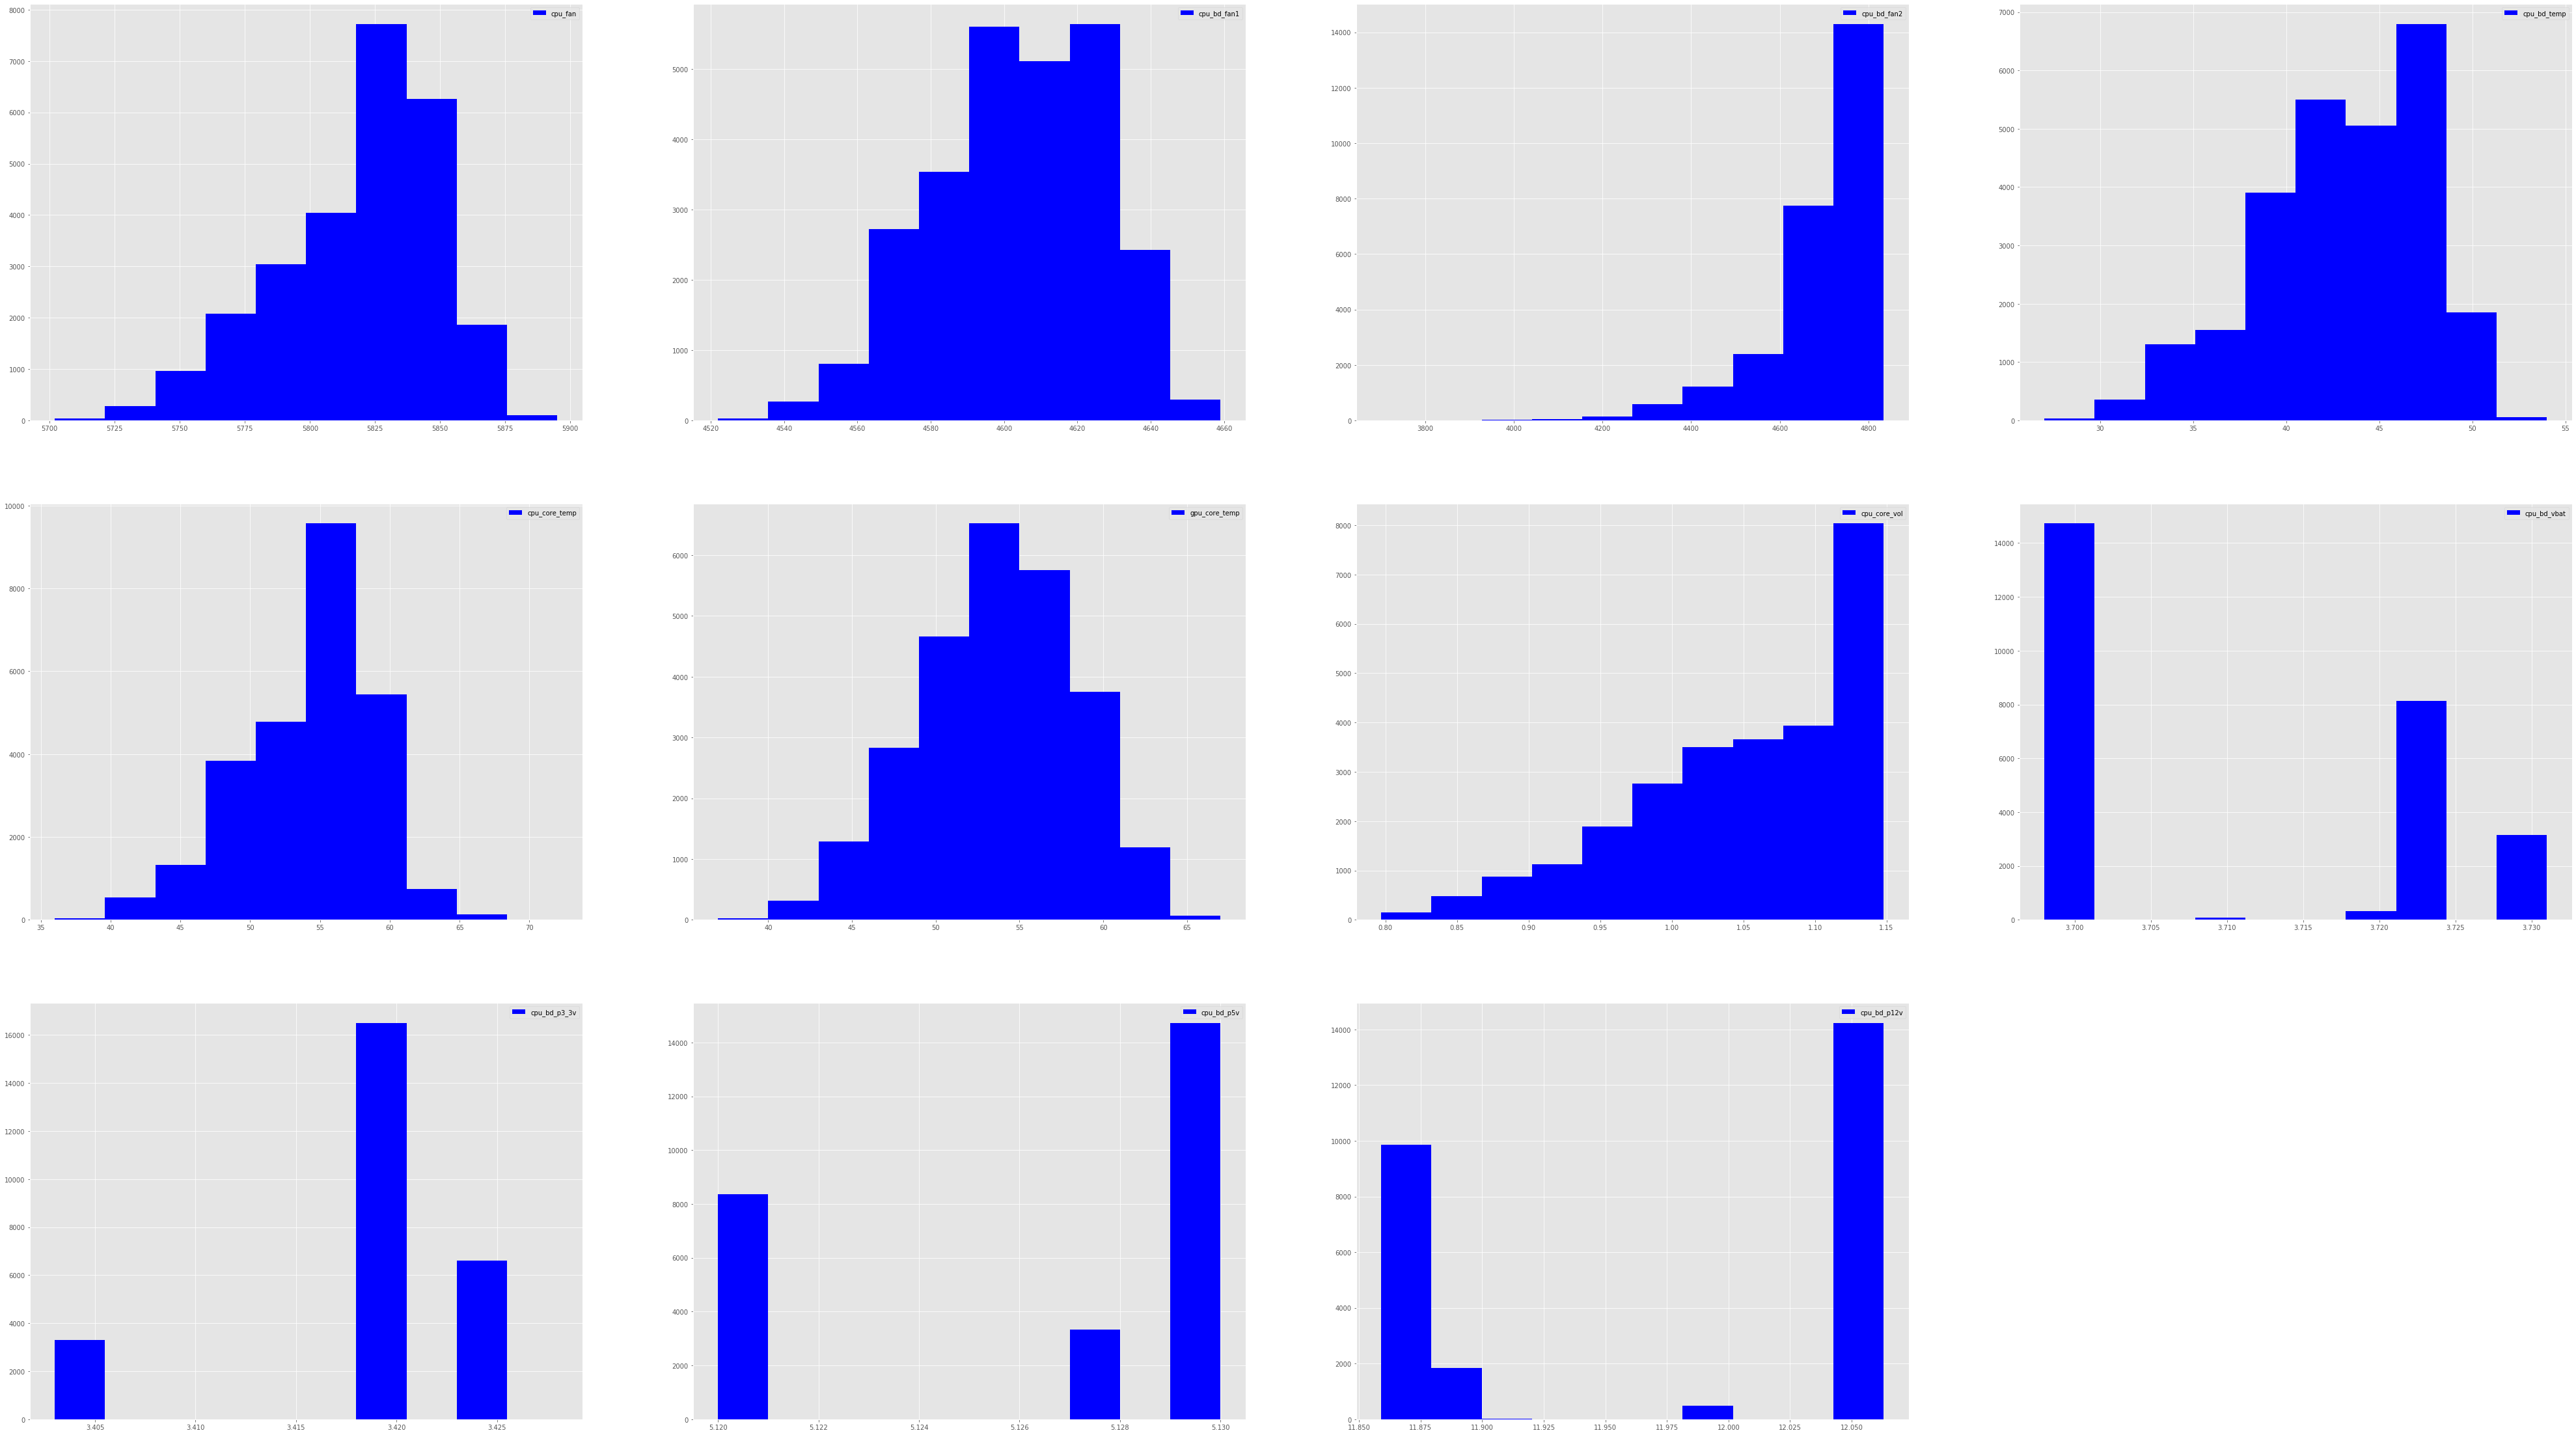

In [ ]:
fig = plt.figure(figsize=(70,40))
column_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

column_list2=["cpu_fan","cpu_bd_fan1"
             ,"cpu_bd_fan2","cpu_bd_temp"
             ,"cpu_core_temp","gpu_core_temp"
             ,"cpu_core_vol","cpu_bd_vbat"
             ,"cpu_bd_p3_3v","cpu_bd_p5v"
             ,"cpu_bd_p12v"]

check_hist=data_ADP555[data_ADP555["id"]=="9748019T-325"]

for i,label in enumerate(column_list):
    ax = fig.add_subplot(3,4,i+1)
    ax.hist(check_hist[label], color="b", label=column_list2[i] ,bins=10)
    ax.legend()

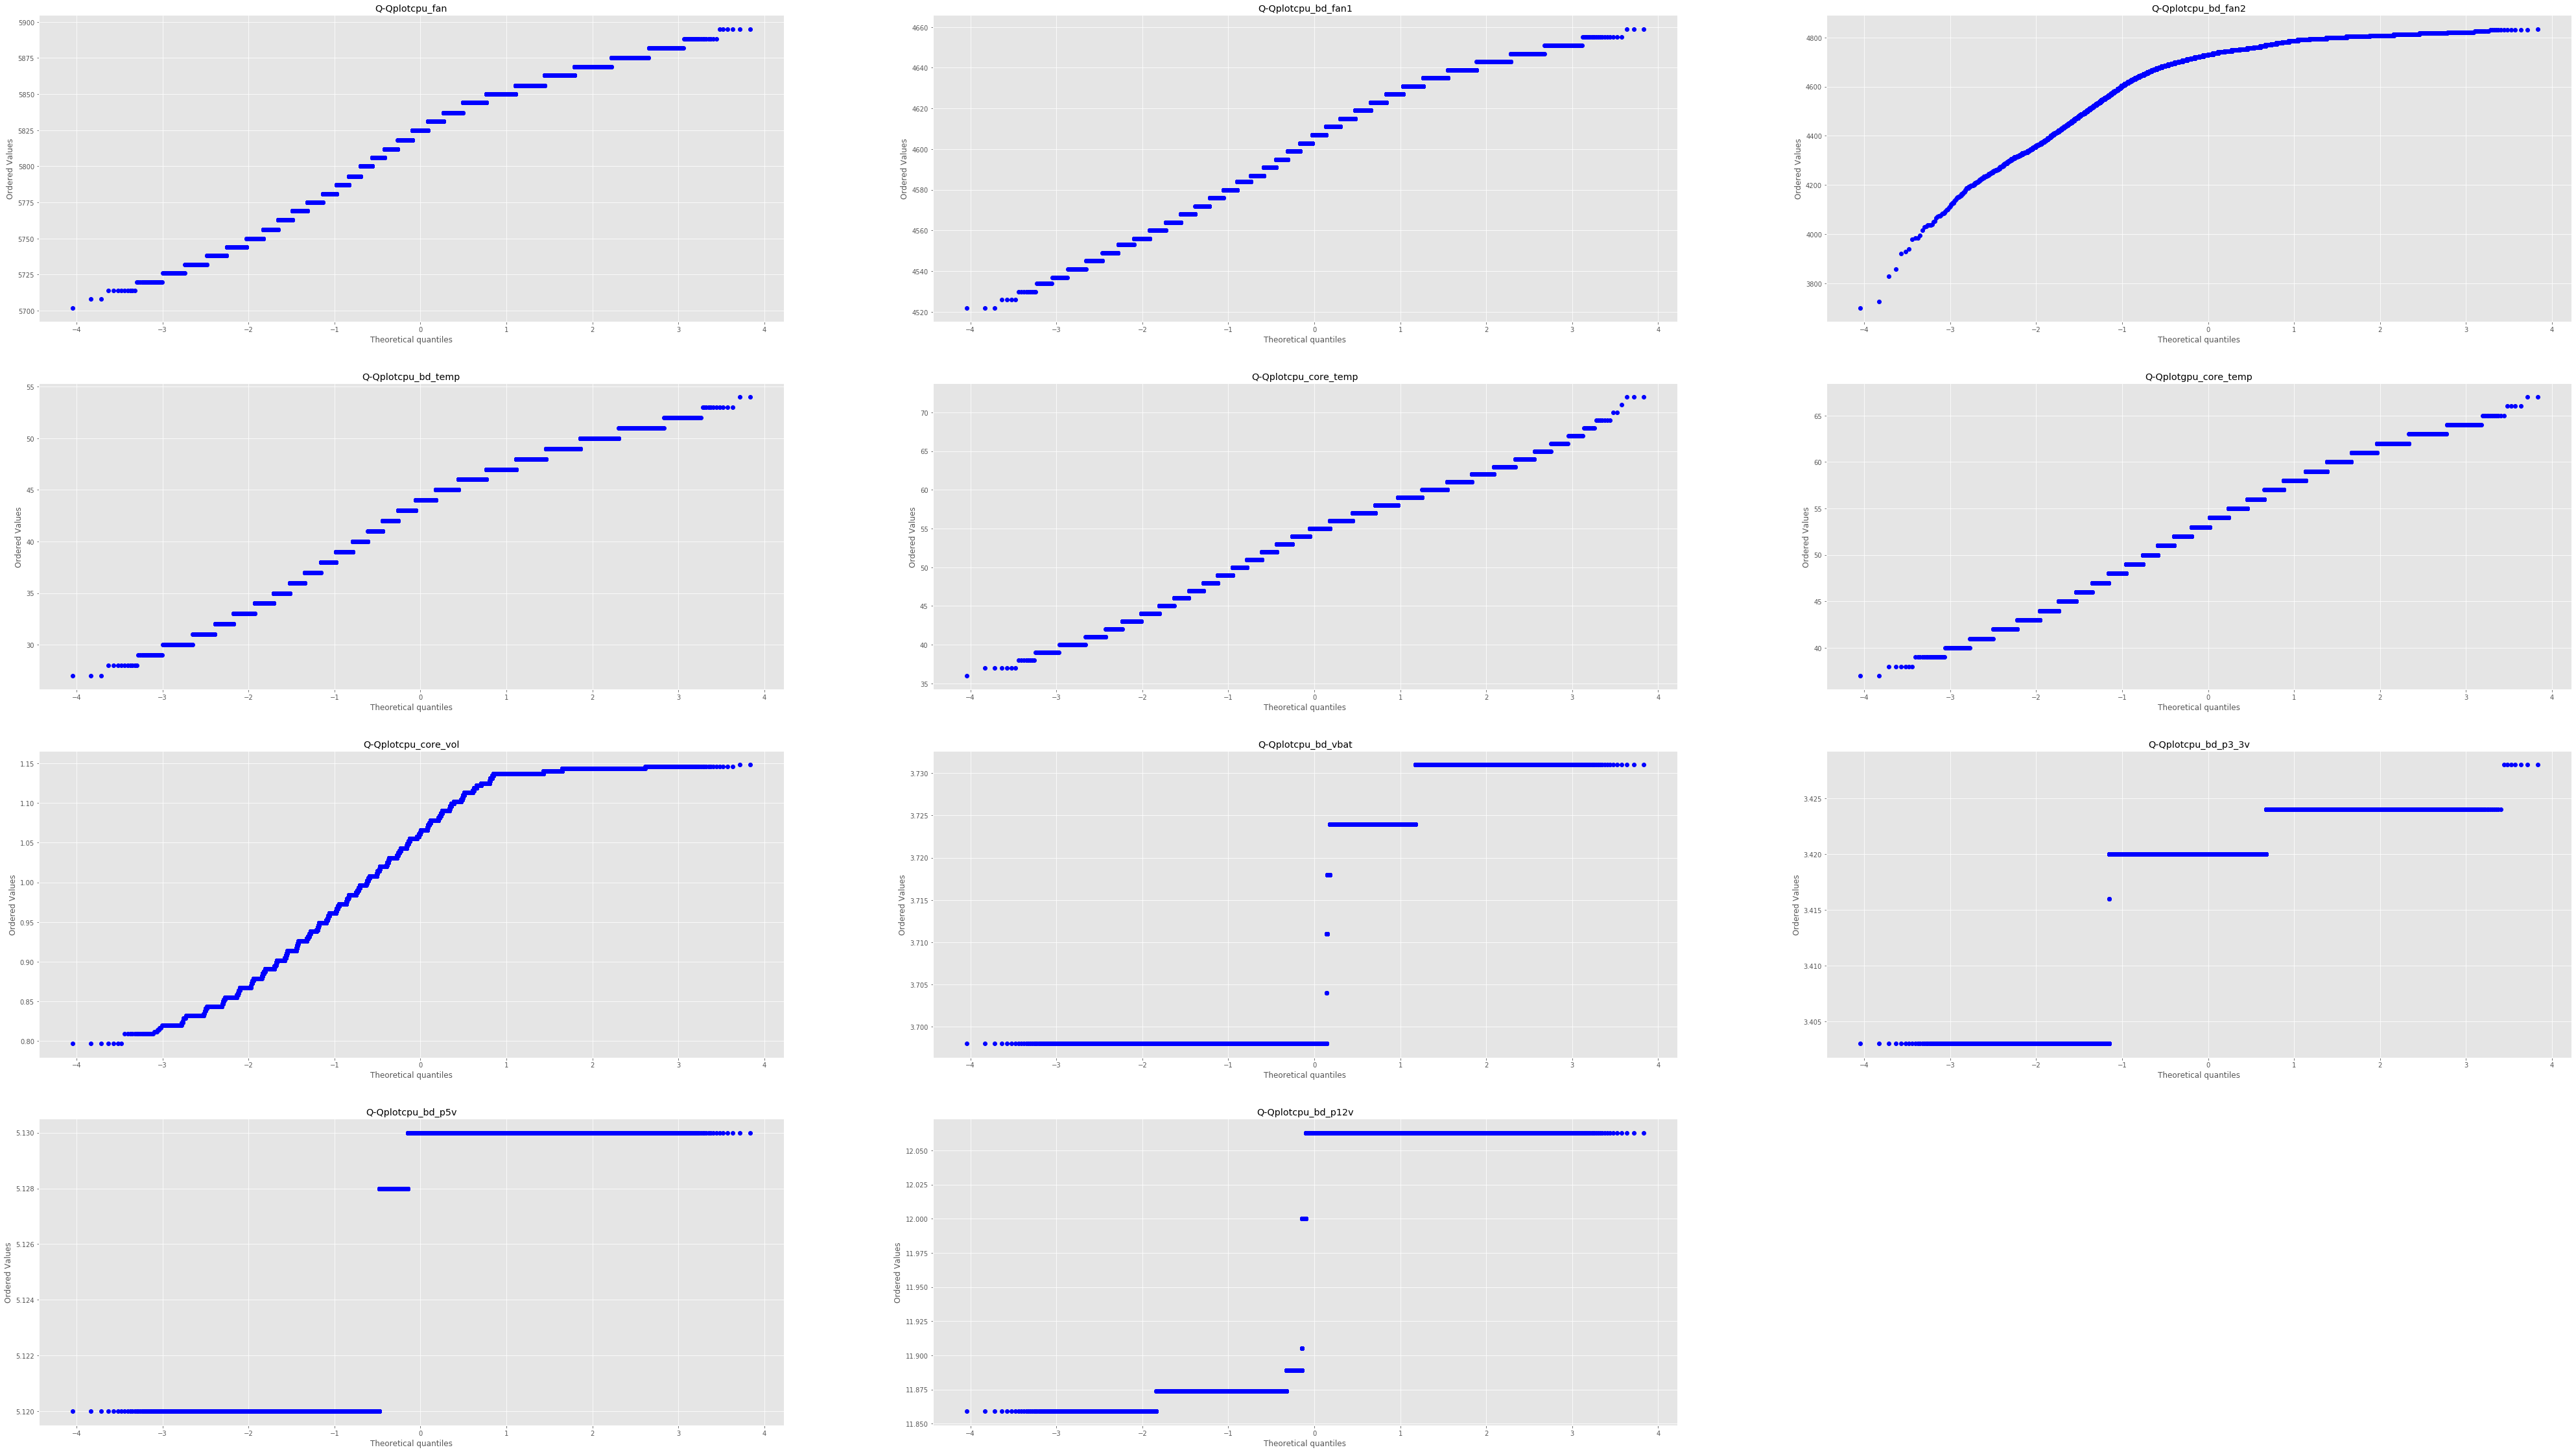

In [ ]:
fig = plt.figure(figsize=(70,40))
column_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

column_list2=["cpu_fan","cpu_bd_fan1"
             ,"cpu_bd_fan2","cpu_bd_temp"
             ,"cpu_core_temp","gpu_core_temp"
             ,"cpu_core_vol","cpu_bd_vbat"
             ,"cpu_bd_p3_3v","cpu_bd_p5v"
             ,"cpu_bd_p12v"]

check_hist=data_ADP555[data_ADP555["id"]=="9748019T-325"]

for i,label in enumerate(column_list):
    ax = fig.add_subplot(4,3,i+1)
    stats.probplot(check_hist[label], dist="norm", plot=plt)
    ax.set_title("Q-Qplot" + str(column_list2[i]))

# OCSVM & MT   CPU型式 ADP-555
## パラメータ　Cの分子:1000　γ:0.1

In [ ]:
Select_id_data_set=data_ADP555[data_ADP555["id"]=="9748019T-325"]
colums_list=["processor_unit_units_status_cpu_board_cpu_fan","processor_unit_units_status_cpu_board_cpu_bd_fan1"
             ,"processor_unit_units_status_cpu_board_cpu_bd_fan2","processor_unit_units_status_cpu_board_cpu_bd_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_temp","processor_unit_units_status_cpu_board_gpu_core_temp"
             ,"processor_unit_units_status_cpu_board_cpu_core_vol","processor_unit_units_status_cpu_board_cpu_bd_vbat"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p3_3v","processor_unit_units_status_cpu_board_cpu_bd_p5v"
             ,"processor_unit_units_status_cpu_board_cpu_bd_p12v"]

# MT法を入れたver

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')     

import math
import os

# 保存先
ans_data_set_no_cor=pd.DataFrame()

# パラメータ
NU=0.02
gam=1.0

# 準備
data_OCSVM = Select_id_data_set[colums_list+["measurement_date"]]
data_OCSVM=data_OCSVM.dropna(how='any')
data_OCSVM=data_OCSVM.reset_index(drop = True)
data_OCSVM["measurement_date"]=pd.to_datetime(data_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')

Select_data=data_OCSVM["measurement_date"][0]
data_year=Select_data.year+2
data_month=Select_data.month
end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"

# for文の回数
data_len=len(data_OCSVM)
for_times=15
print("for文の回数：",for_times)

#------------------------------------------------------------------------
# スタートの傾き・モデル作成
print("-------------------------モデル1-----------------------------")
model_data=data_OCSVM[data_OCSVM["measurement_date"]<end_data]
print("OCSVMトレーニング期間終了",end_data)
model_data=model_data[colums_list]
model_data=model_data.values

mm_ADP555 = preprocessing.MinMaxScaler()
train_OCSVM = mm_ADP555.fit_transform((model_data).reshape(len(model_data), -1))
train_OCSVM += 0.0001

model_ADP555 = svm.OneClassSVM(nu=NU,gamma=gam,kernel="rbf")
model_ADP555.fit(train_OCSVM)
pre_train=model_ADP555.predict(train_OCSVM)
print("設定異常割合：{:.2%}".format(NU),"\t\t学習異常割合：{:.2%}".format(len(pre_train[pre_train<0])/len(train_OCSVM)))
# print("傾き",model_ADP555.coef_)
# print("切片",model_ADP555.intercept_)
print("データ数",len(train_OCSVM))
print("サポートベクター数",len(model_ADP555.support_vectors_),"\n")

#------------------------------------------------------------------------

for i in range(for_times):
    start_data=end_data
    if data_month==12:
        data_month=1
        data_year+=1
    else:
        data_month+=1
    end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    print("OCSVMテスト期間開始",start_data)
    print("OCSVMテスト期間終了",end_data)
    
    test_data=data_OCSVM[(data_OCSVM["measurement_date"]>=start_data)&(data_OCSVM["measurement_date"]<end_data)]
    data_set=test_data[["measurement_date"]+colums_list].reset_index(drop = True)
    test_data=test_data[colums_list].reset_index(drop = True)
    test_data=test_data.values
    
#------------------------------------------------------------------------
# テスト開始
#     coef_list=pd.DataFrame()
#     intercept_list=pd.DataFrame()
#     Model_data=pd.DataFrame()
    
        
#     intercept=pd.DataFrame(model_ADP555.intercept_)
#     intercept_list=pd.concat([intercept_list,intercept], ignore_index=True)

#     coef=pd.DataFrame(model_ADP555.coef_)
#     coef_list=pd.concat([coef_list,coef], ignore_index=True)

#     model_ave=pd.DataFrame(train_OCSVM.mean(axis=0))
#     model_ave=model_ave.T
#     Model_data=pd.concat([Model_data,model_ave], ignore_index=True)
    

    test_OCSVM = mm_ADP555.transform((test_data).reshape(len(test_data), -1))
    test_OCSVM += 0.0001
    print("テストデータ数：",len(test_OCSVM))
    MinMax_data=pd.DataFrame(test_OCSVM)
    score_set_OCSVM=model_ADP555.decision_function(test_OCSVM)*(-1)
    score_set_OCSVM=pd.DataFrame(score_set_OCSVM)
    
    test_data_MT=data_OCSVM[(data_OCSVM["measurement_date"]>=start_data)&(data_OCSVM["measurement_date"]<end_data)]
    data_MT=test_data_MT[colums_list].reset_index(drop = True)
    data_MT=data_MT.values
    
    data_month_MT=0
    if data_month==1:
        data_month_MT=12
    else:
        data_month_MT=data_month-1

    start_data_MT=str(data_year-1)+"/"+str(data_month_MT)+"/01 00:00:00"
    normal_MT=data_OCSVM[(data_OCSVM["measurement_date"]>=start_data_MT)&(data_OCSVM["measurement_date"]<end_data)]
    normal_MT=normal_MT[colums_list].reset_index(drop = True)
    normal_MT=normal_MT.values
    print("MT期間開始",start_data_MT)
    print("MT期間終了",end_data)
    print("MTテスト期間開始",start_data)
    print("MTテスト期間終了",end_data)
    print("MTデータ数",len(normal_MT))

    # 異常値の計算
    mx = np.mean(normal_MT,axis=0 ) # 標本平均
    Xc = data_MT - mx         # 中心化したデータ行列
    Sx = np.cov(normal_MT, rowvar=0, bias=1) # 標本共分散行列 
    score_set_MT= (Xc.dot(np.linalg.pinv(Sx)) * Xc).sum(axis=1) / data_MT.shape[1] # 1変数当たりの異常度
    score_set_MT=pd.DataFrame(score_set_MT)
    

    dt_anormaly = pd.DataFrame({"measurement_date": data_set["measurement_date"],
                                "processor_unit_units_status_cpu_board_cpu_fan": data_set["processor_unit_units_status_cpu_board_cpu_fan"],
                                "processor_unit_units_status_cpu_board_cpu_bd_fan1": data_set["processor_unit_units_status_cpu_board_cpu_bd_fan1"],
                                "processor_unit_units_status_cpu_board_cpu_bd_fan2": data_set["processor_unit_units_status_cpu_board_cpu_bd_fan2"],
                                "processor_unit_units_status_cpu_board_cpu_bd_temp": data_set["processor_unit_units_status_cpu_board_cpu_bd_temp"],
                                "processor_unit_units_status_cpu_board_cpu_core_temp": data_set["processor_unit_units_status_cpu_board_cpu_core_temp"],
                                "processor_unit_units_status_cpu_board_gpu_core_temp": data_set["processor_unit_units_status_cpu_board_gpu_core_temp"],
                                "processor_unit_units_status_cpu_board_cpu_core_vol": data_set["processor_unit_units_status_cpu_board_cpu_core_vol"],
                                "processor_unit_units_status_cpu_board_cpu_bd_vbat": data_set["processor_unit_units_status_cpu_board_cpu_bd_vbat"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p3_3v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p3_3v"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p5v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p5v"],
                                "processor_unit_units_status_cpu_board_cpu_bd_p12v": data_set["processor_unit_units_status_cpu_board_cpu_bd_p12v"],
#                                 "coef_cpu_fan": coef_list[0],
#                                 "coef_cpu_bd_fan1": coef_list[1],
#                                 "coef_cpu_bd_fan2": coef_list[2],
#                                 "coef_cpu_bd_temp": coef_list[3],
#                                 "coef_cpu_core_temp": coef_list[4],
#                                 "coef_gpu_core_temp": coef_list[5],
#                                 "coef_cpu_core_vol": coef_list[6],
#                                 "coef_cpu_bd_vbat": coef_list[7],
#                                 "coef_cpu_bd_p3_3v": coef_list[8],
#                                 "coef_cpu_bd_p5v": coef_list[9],
#                                 "coef_cpu_bd_p12v": coef_list[10],
#                                 "intercept": intercept_list[0],
                                "MM_cpu_fan": MinMax_data[0],
                                "MM_cpu_bd_fan1": MinMax_data[1],
                                "MM_cpu_bd_fan2": MinMax_data[2],
                                "MM_cpu_bd_temp": MinMax_data[3],
                                "MM_cpu_core_temp": MinMax_data[4],
                                "MM_gpu_core_temp": MinMax_data[5],
                                "MM_cpu_core_vol": MinMax_data[6],
                                "MM_cpu_bd_vbat": MinMax_data[7],
                                "MM_cpu_bd_p3_3v": MinMax_data[8],
                                "MM_cpu_bd_p5v": MinMax_data[9],
                                "MM_cpu_bd_p12v": MinMax_data[10],
#                                 "Model_cpu_fan": Model_data[0],
#                                 "Model_cpu_bd_fan1": Model_data[1],
#                                 "Model_cpu_bd_fan2": Model_data[2],
#                                 "Model_cpu_bd_temp": Model_data[3],
#                                 "Model_cpu_core_temp": Model_data[4],
#                                 "Model_gpu_core_temp": Model_data[5],
#                                 "Model_cpu_core_vol": Model_data[6],
#                                 "Model_cpu_bd_vbat": Model_data[7],
#                                 "Model_cpu_bd_p3_3v": Model_data[8],
#                                 "Model_cpu_bd_p5v": Model_data[9],
#                                 "Model_cpu_bd_p12v": Model_data[10],
                                "score_abnormal_OCSVM":score_set_OCSVM[0],
                                "score_abnormal_MT":score_set_MT[0]
                                }).reset_index(drop = True)
    ans_data_set_no_cor=pd.concat([ans_data_set_no_cor,dt_anormaly], ignore_index=True)
#------------------------------------------------------------------------
    train_start_data=str(data_year-2)+"/"+str(data_month)+"/01 00:00:00"
    train_end_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    
    print("-------------------------モデル"+str(i+2)+"-----------------------------")
    print("OCSVMトレーニング期間開始",train_start_data)
    print("OCSVMトレーニング期間終了",train_end_data)
    
    model_data=data_OCSVM[(data_OCSVM["measurement_date"]>=train_start_data)&(data_OCSVM["measurement_date"]<train_end_data)]
    
    model_data=model_data[colums_list]
    cor=model_data.corr()
    cor=cor.values
    model_data=model_data.values
    
    mm_ADP555 = preprocessing.MinMaxScaler()
    train_OCSVM = mm_ADP555.fit_transform((model_data).reshape(len(model_data), -1))
    train_OCSVM += 0.0001

    model_ADP555 = svm.OneClassSVM(nu=NU,gamma=gam,kernel="rbf")
    model_ADP555.fit(train_OCSVM)
    pre_train=model_ADP555.predict(train_OCSVM)
    print("設定異常割合：{:.2%}".format(NU),"\t\t学習異常割合：{:.2%}".format(len(pre_train[pre_train<0])/len(train_OCSVM)))
#     print("傾き",model_ADP555.coef_)
#     print("切片",model_ADP555.intercept_)
    print("データ数",len(train_OCSVM))
    print("サポートベクター数",len(model_ADP555.support_vectors_),"\n")
#------------------------------------------------------------------------

2023/03/10 15:13
for文の回数： 15
-------------------------モデル1-----------------------------
OCSVMトレーニング期間終了 2017/12/01 00:00:00
設定異常割合：2.00% 		学習異常割合：1.99%
データ数 16602
サポートベクター数 341 

OCSVMテスト期間開始 2017/12/01 00:00:00
OCSVMテスト期間終了 2018/1/01 00:00:00
テストデータ数： 740
MT期間開始 2017/12/01 00:00:00
MT期間終了 2018/1/01 00:00:00
MTテスト期間開始 2017/12/01 00:00:00
MTテスト期間終了 2018/1/01 00:00:00
MTデータ数 740
-------------------------モデル2-----------------------------
OCSVMトレーニング期間開始 2016/1/01 00:00:00
OCSVMトレーニング期間終了 2018/1/01 00:00:00
設定異常割合：2.00% 		学習異常割合：2.00%
データ数 17133
サポートベクター数 358 

OCSVMテスト期間開始 2018/1/01 00:00:00
OCSVMテスト期間終了 2018/2/01 00:00:00
テストデータ数： 744
MT期間開始 2017/1/01 00:00:00
MT期間終了 2018/2/01 00:00:00
MTテスト期間開始 2018/1/01 00:00:00
MTテスト期間終了 2018/2/01 00:00:00
MTデータ数 9362
-------------------------モデル3-----------------------------
OCSVMトレーニング期間開始 2016/2/01 00:00:00
OCSVMトレーニング期間終了 2018/2/01 00:00:00
設定異常割合：2.00% 		学習異常割合：1.99%
データ数 17133
サポートベクター数 356 

OCSVMテスト期間開始 2018/2/01 00:00:00
OCSVMテスト期間終了 2018/3/0

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


2023/03/10 15:13


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


データ数： 9823
1-class SVM異常検知個数： 1128
1-class SVM異常検知割合：11.48%
MT異常検知個数： 99
MT異常検知割合：1.01%
Wall time: 341 ms


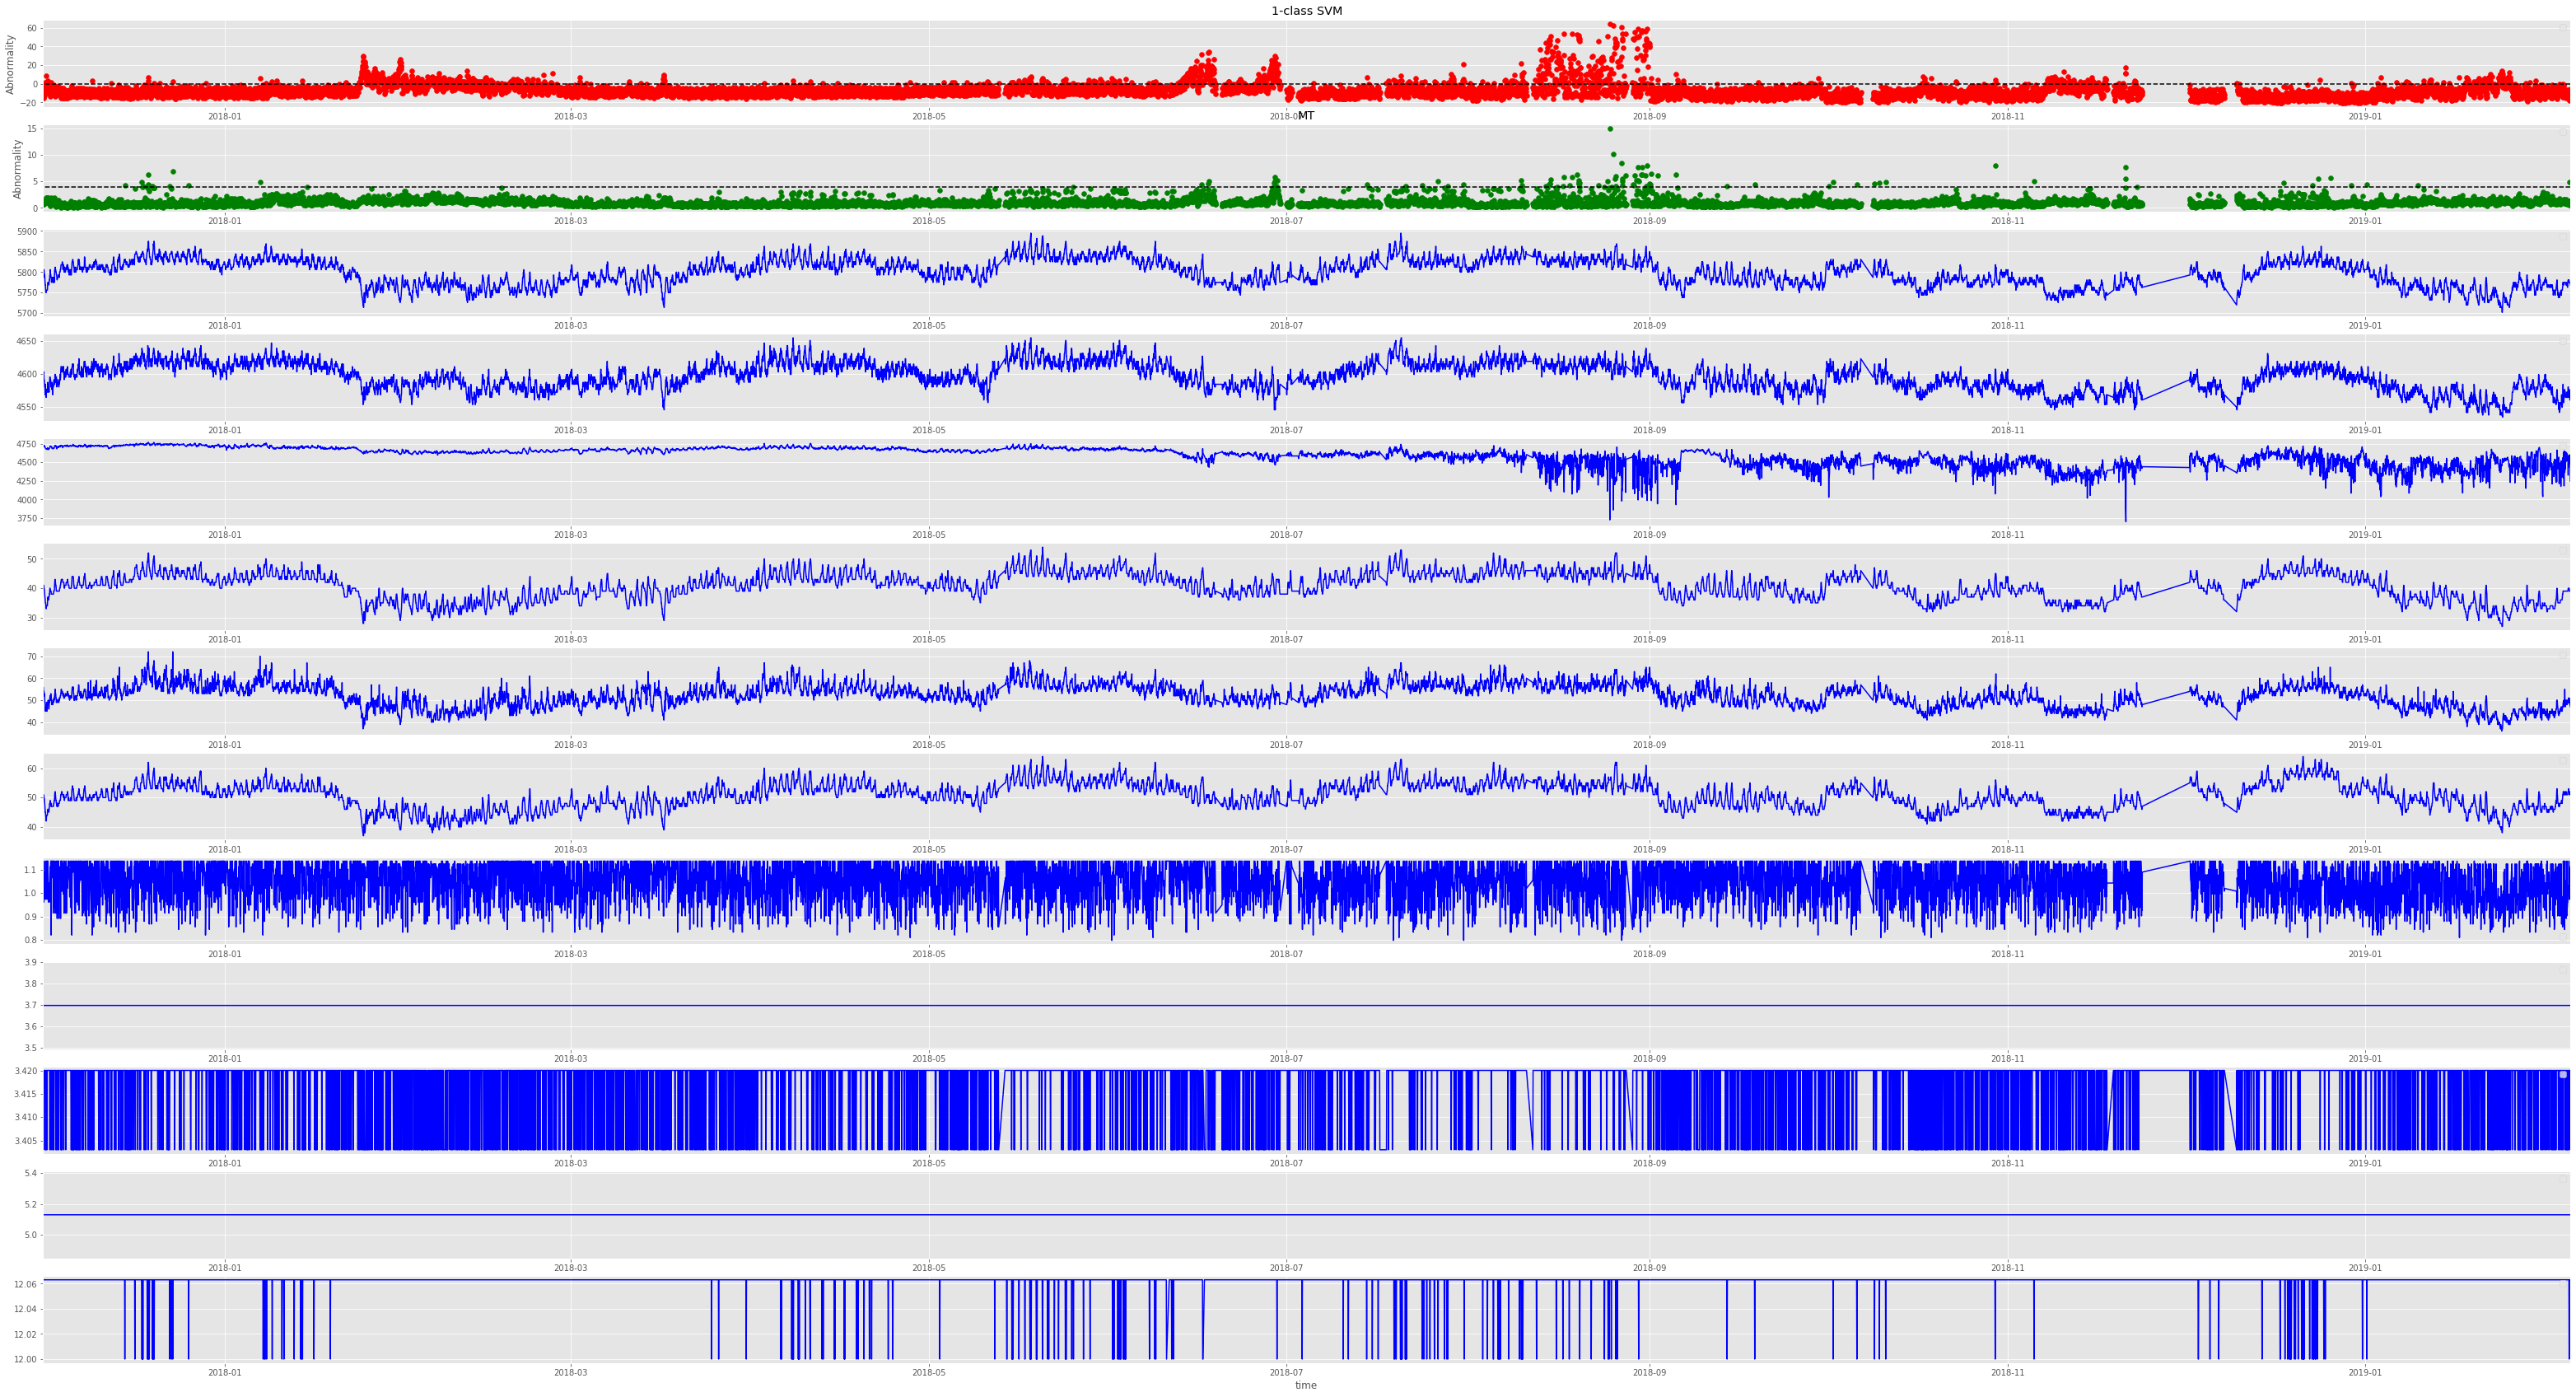

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 

time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')

fig = plt.figure(figsize=(55,30))
ax1 = fig.add_subplot(13,1,1)
ax1.set_title("1-class SVM")
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_OCSVM"], color='r')
ax1.set_ylabel('Abnormality')
ax1.hlines(0,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()


ax1 = fig.add_subplot(13,1,2)
ax1.set_title("MT")
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_MT"], color='green')
ax1.set_ylabel('Abnormality')
ax1.hlines(4,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()

# 元データ
for i, column in enumerate (colums_list):
    ax = fig.add_subplot(13,1,i+3)
    ax.plot(time,ans_data_set_no_cor[column], color='b')
    ax.set_xlabel('time')
    ax.set_xlim(time.min(),time.max())
    ax.legend()

print("データ数：",ans_data_set_no_cor["score_abnormal_OCSVM"].count())
print("1-class SVM異常検知個数：",ans_data_set_no_cor.query("score_abnormal_OCSVM>0")["score_abnormal_OCSVM"].count())
print("1-class SVM異常検知割合：{:.2%}".format(ans_data_set_no_cor.query("score_abnormal_OCSVM>0")["score_abnormal_OCSVM"].count()/ans_data_set_no_cor["score_abnormal_OCSVM"].count()))


print("MT異常検知個数：",ans_data_set_no_cor.query("score_abnormal_MT>4")["score_abnormal_MT"].count())
print("MT異常検知割合：{:.2%}".format(ans_data_set_no_cor.query("score_abnormal_MT>4")["score_abnormal_MT"].count()/ans_data_set_no_cor["score_abnormal_MT"].count()))

No handles with labels found to put in legend.
No handles with labels found to put in legend.


2023/03/10 15:13
Wall time: 120 ms


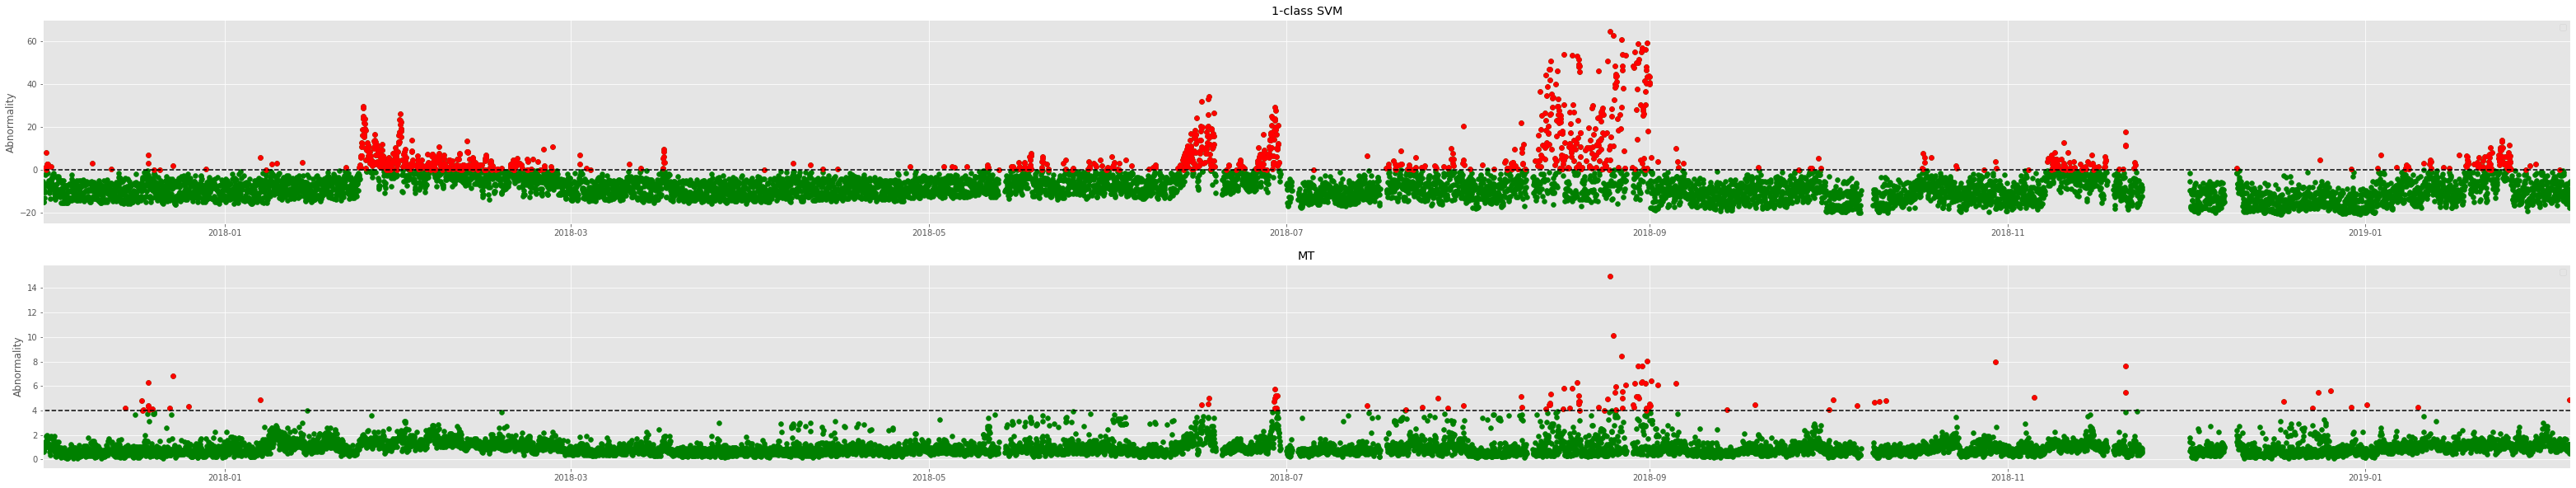

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 

time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')

select_OCSVM=ans_data_set_no_cor[ans_data_set_no_cor["score_abnormal_OCSVM"]>0]
select_MT=ans_data_set_no_cor[ans_data_set_no_cor["score_abnormal_MT"]>4]

time1 = pd.to_datetime(select_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time2 = pd.to_datetime(select_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')

fig = plt.figure(figsize=(55,10))
ax1 = fig.add_subplot(2,1,1)
ax1.set_title("1-class SVM")
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_OCSVM"], color='g')
ax1.scatter(time1,select_OCSVM["score_abnormal_OCSVM"], color='r')
ax1.set_ylabel('Abnormality')
ax1.hlines(0,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()


ax1 = fig.add_subplot(2,1,2)
ax1.set_title("MT")
ax1.scatter(time,ans_data_set_no_cor["score_abnormal_MT"], color='g')
ax1.scatter(time2,select_MT["score_abnormal_MT"], color='r')
ax1.set_ylabel('Abnormality')
ax1.hlines(4,time.max(),time.min(), color='black',linestyles='dashed')
ax1.set_xlim(time.min(),time.max())
ax1.legend()

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')

only_MT=0
only_OCSVM=0
MT_OCSVM=0

time = pd.to_datetime(ans_data_set_no_cor["measurement_date"], format='%Y/%m/%d %H:%M:%S')
only_MT=ans_data_set_no_cor[(ans_data_set_no_cor["score_abnormal_MT"]>4)&(ans_data_set_no_cor["score_abnormal_OCSVM"]<=0)]
only_OCSVM=ans_data_set_no_cor[(ans_data_set_no_cor["score_abnormal_MT"]<=4)&(ans_data_set_no_cor["score_abnormal_OCSVM"]>0)]
MT_OCSVM=ans_data_set_no_cor[(ans_data_set_no_cor["score_abnormal_MT"]>4)&(ans_data_set_no_cor["score_abnormal_OCSVM"]>0)]
NoMT_NoOCSVM=ans_data_set_no_cor[(ans_data_set_no_cor["score_abnormal_MT"]<=4)&(ans_data_set_no_cor["score_abnormal_OCSVM"]<=0)]
abnormal=ans_data_set_no_cor[(ans_data_set_no_cor["score_abnormal_MT"]>4)|(ans_data_set_no_cor["score_abnormal_OCSVM"]>0)]
print("MTのみ：",len(only_MT))
print("1-Classのみ：",len(only_OCSVM))
print("両方：",len(MT_OCSVM))
print("両方正常：",len(NoMT_NoOCSVM))
print("片方異常：",len(abnormal))

2023/03/10 15:13
MTのみ： 29
1-Classのみ： 1058
両方： 70
両方正常： 8666
片方異常： 1157
Wall time: 20.9 ms


In [ ]:
print(len(ans_data_set_no_cor))
print()

9823



No handles with labels found to put in legend.


2023/03/10 15:13
Wall time: 54.5 ms


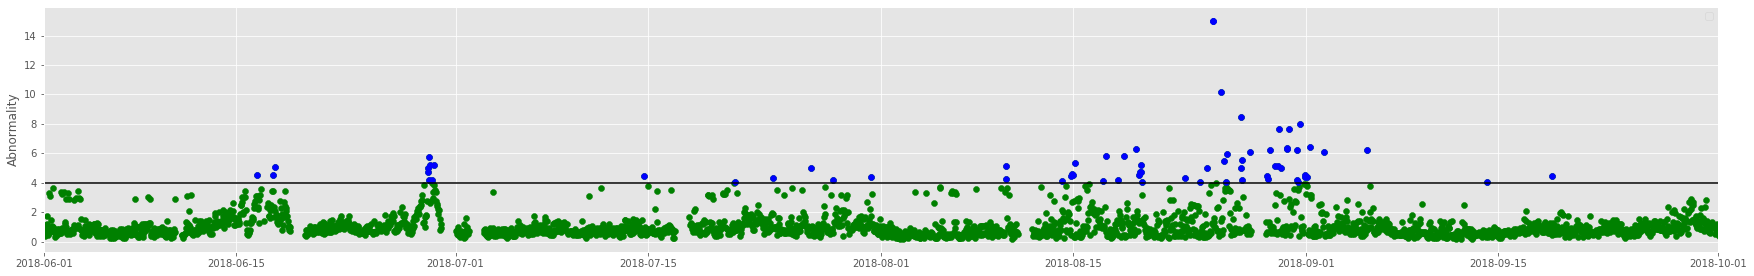

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 

check_hist_All=ans_data_set_no_cor


time1 = pd.to_datetime(check_hist_All["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time2 = pd.to_datetime(only_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time3 = pd.to_datetime(only_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time4 = pd.to_datetime(MT_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')

time_min = pd.to_datetime("2018/06/01 00:00:00", format='%Y/%m/%d %H:%M:%S')
time_max = pd.to_datetime("2018/10/01 00:00:00", format='%Y/%m/%d %H:%M:%S')

time_ocsvm = pd.to_datetime(select_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time_mt = pd.to_datetime(select_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')

time_anomaly=pd.to_datetime("2018/08/25 04:00:03", format='%Y/%m/%d %H:%M:%S')
anormaly_select_OCSVM=select_OCSVM[select_OCSVM["measurement_date"]=="2018/08/25 04:00:03"]
anormaly_select_MT=select_MT[select_MT["measurement_date"]=="2018/08/25 04:00:03"]

fig = plt.figure(figsize=(30,4.5))
# ax1 = fig.add_subplot(3,1,1)
# ax1.scatter(time1,check_hist_All["score_abnormal_OCSVM"], color='darkgray')
# ax1.scatter(time4,MT_OCSVM["score_abnormal_OCSVM"], color='r')
# ax1.scatter(time3,only_OCSVM["score_abnormal_OCSVM"], color='deepskyblue')
# ax1.scatter(time2,only_MT["score_abnormal_OCSVM"], color='indigo')
# ax1.set_xlim(time_min,time_max)
# ax1.set_ylabel('Abnormality')
# ax1.hlines(0,time1.max(),time1.min(), color='black')
# ax1.legend()


# ax1 = fig.add_subplot(3,1,2)
# ax1.scatter(time1,check_hist_All["score_abnormal_OCSVM"], color='green')
# ax1.scatter(time_ocsvm,select_OCSVM["score_abnormal_OCSVM"], color='blue')
# ax1.scatter(time_anomaly,anormaly_select_OCSVM["score_abnormal_OCSVM"], color='red')
# ax1.set_ylabel('Abnormality')
# ax1.hlines(0,time1.max(),time1.min(), color='black')
# ax1.set_xlim(time_min,time_max)
# ax1.legend()


ax1 = fig.add_subplot(1,1,1)
ax1.scatter(time1,check_hist_All["score_abnormal_MT"], color='green')
ax1.scatter(time_mt,select_MT["score_abnormal_MT"], color='blue')
ax1.scatter(time_anomaly,anormaly_select_MT["score_abnormal_MT"], color='blue')
ax1.set_ylabel('Abnormality')
ax1.hlines(4,time1.max(),time1.min(), color='black')
ax1.set_xlim(time_min,time_max)
ax1.legend()




# # 元データ
# for i, column in enumerate (colums_list):
#     ax = fig.add_subplot(12,1,i+2)
#     ax.scatter(time1,check_hist_All[column], color="darkgray")
#     ax.scatter(time4,MT_OCSVM[column], color='r')
#     ax.scatter(time3,only_OCSVM[column], color='deepskyblue')
#     ax.scatter(time2,only_MT[column], color='indigo')
#     ax.set_xlim(time_min,time_max)
#     ax.legend()

# 20220923 CHECK

In [ ]:
# ab_3_MT=ans_data_set_no_cor[ans_data_set_no_cor["score_abnormal_OCSVM"]>0]
# ab_3_MT["measurement_date"]

In [ ]:
# ab_3_MT["measurement_date"].to_csv('20220923_OCSVM_中間発表.csv', index=False)

No handles with labels found to put in legend.


2023/03/10 15:13
2757
1 1041
2 323
3 169
4 68
Wall time: 34.2 ms


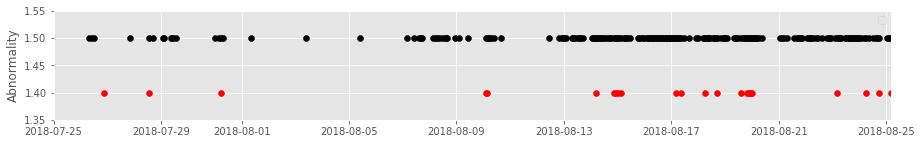

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore') 

check_hist_All=ans_data_set_no_cor

check_hist_All=check_hist_All[(check_hist_All["measurement_date"]<time_max)&(check_hist_All["measurement_date"]>=time_min)]

ab_4_MT=check_hist_All[check_hist_All["score_abnormal_MT"]>4]
ab_3_MT=check_hist_All[check_hist_All["score_abnormal_MT"]>3]
ab_2_MT=check_hist_All[check_hist_All["score_abnormal_MT"]>2]
ab_1_MT=check_hist_All[check_hist_All["score_abnormal_MT"]>1]


ab_OCSVM=check_hist_All[check_hist_All["score_abnormal_OCSVM"]>0]

ab_1_MT["1"]=1.1
ab_4_MT["4"]=1.4
ab_3_MT["3"]=1.3
ab_2_MT["2"]=1.2
ab_OCSVM["5"]=1.5



time5 = pd.to_datetime(ab_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time1 = pd.to_datetime(ab_1_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time2 = pd.to_datetime(ab_2_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time3 = pd.to_datetime(ab_3_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')
time4 = pd.to_datetime(ab_4_MT["measurement_date"], format='%Y/%m/%d %H:%M:%S')

time_min = pd.to_datetime("2018/07/25 00:00:00", format='%Y/%m/%d %H:%M:%S')
time_max = pd.to_datetime("2018/8/25 04:00:00", format='%Y/%m/%d %H:%M:%S')

print(len(check_hist_All))
fig = plt.figure(figsize=(15,2))
ax1 = fig.add_subplot(1,1,1)
ax1.scatter(time5,ab_OCSVM["5"], color='black')
# ax1.scatter(time1,ab_1_MT["1"], color='green')
# ax1.scatter(time2,ab_2_MT["2"], color='indigo')
# ax1.scatter(time3,ab_3_MT["3"], color='deepskyblue')
ax1.scatter(time4,ab_4_MT["4"], color='r')
ax1.set_ylim(1.35,1.55)

print("1",len(ab_1_MT["1"]))
print("2",len(ab_2_MT["2"]))
print("3",len(ab_3_MT["3"]))
print("4",len(ab_4_MT["4"]))

ax1.set_xlim(time_min,time_max)
ax1.set_ylabel('Abnormality')
ax1.legend()


# ax1 = fig.add_subplot(3,1,2)
# ax1.scatter(time1,check_hist_All["score_abnormal_OCSVM"], color='g')
# ax1.scatter(time_ocsvm,select_OCSVM["score_abnormal_OCSVM"], color='brown')
# ax1.set_ylabel('Abnormality')
# ax1.hlines(0,time1.max(),time1.min(), color='black')
# ax1.set_xlim(time_min,time_max)
# ax1.legend()


# ax1 = fig.add_subplot(3,1,3)
# ax1.scatter(time1,check_hist_All["score_abnormal_MT"], color='g')
# ax1.scatter(time_mt,select_MT["score_abnormal_MT"], color='brown')
# ax1.set_ylabel('Abnormality')
# ax1.hlines(4,time1.max(),time1.min(), color='black')
# ax1.set_xlim(time_min,time_max)
# ax1.legend()

In [ ]:
# MT_OCSVM_list["measurement_date"].unique()

# SN比チェック

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')    

import math
import os

# パラメータ
NU=0.02
gam=1.0

# 準備
data_OCSVM=ans_data_set_no_cor
data_OCSVM=data_OCSVM.dropna(how='any')
data_OCSVM=data_OCSVM.reset_index(drop = True)
data_OCSVM["measurement_date"]=pd.to_datetime(data_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')



MT_OCSVM_list=ab_4_MT.reset_index(drop = True)

for i in range(len(MT_OCSVM_list["measurement_date"].unique())):
    Select_date=MT_OCSVM_list["measurement_date"][i]
#     print("調べるデータ：",Select_date)
    data_year=Select_date.year
    data_month=Select_date.month

    test_month_MT=0
    test_year_MT=data_year
    if data_month==12:
        test_month_MT=1
        test_year_MT=data_year+1
    else:
        test_month_MT=data_month+1
        
    test_start_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    test_end_data=str(test_year_MT)+"/"+str(test_month_MT)+"/01 00:00:00"
    
    train_start_data=str(data_year-2)+"/"+str(data_month)+"/01 00:00:00"
    train_end_data=str(test_year_MT)+"/"+str(test_month_MT)+"/01 00:00:00"

    test_data=data_OCSVM[(data_OCSVM["measurement_date"]>=test_start_data)&(data_OCSVM["measurement_date"]<test_end_data)]
    data_set=test_data[["measurement_date"]+colums_list].reset_index(drop = True)
    a=np.where(data_set["measurement_date"]==MT_OCSVM_list["measurement_date"][i])
    test_data=test_data[colums_list].reset_index(drop = True)        
    test_data=test_data.values

    normal_MT=data_OCSVM[(data_OCSVM["measurement_date"]>=train_start_data)&(data_OCSVM["measurement_date"]<train_end_data)]
    normal_MT=normal_MT[colums_list].reset_index(drop = True)
    normal_MT=normal_MT.values
#     print("MT期間開始",train_start_data)
#     print("MT期間終了",train_end_data)
#     print("MTテスト期間開始",test_start_data)
#     print("MTテスト期間終了",test_end_data)
#     print("MTデータ数",len(normal_MT))
    

    data_MT = test_data
    # 異常値の計算
    mx = np.mean(normal_MT,axis=0 ) # 標本平均
    Xc = data_MT - mx         # 中心化したデータ行列
    Sx = np.cov(normal_MT, rowvar=0, bias=1) # 標本共分散行列 
    score_set_MT= (Xc.dot(np.linalg.pinv(Sx)) * Xc).sum(axis=1) / data_MT.shape[1] # 1変数当たりの異常度

#     fig = plt.figure(figsize=(20,10))
    xc_prime = Xc[a[0][0],:]
    # 中心化行列からCalifのデータ行を取得
    SN1 = 10 * np.log10(xc_prime**2 / np.diag(Sx))
#     print(SN1)
#     plt.bar(range(len(SN1)), SN1, tick_label=["fan","fan1"
#              ,"fan2","bd_temp"
#              ,"core_temp","gpu_core_temp"
#              ,"core_vol","bd_vbat"
#              ,"p3_3v","p5v"
#              ,"p12v"], align="center")
#     plt.title("SN ratio")
#     plt.show()

2023/03/10 15:16
Wall time: 485 ms


In [ ]:
# check_hist_All[check_hist_All["processor_unit_units_status_cpu_board_cpu_bd_p12v"]<12]

In [ ]:
%%time
import time
now = time.ctime()
cnvtime = time.strptime(now)
print(time.strftime("%Y/%m/%d %H:%M", cnvtime))

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore')    

import math
import os

# パラメータ
NU=0.02
gam=1.0

# 準備
data_OCSVM=ans_data_set_no_cor
data_OCSVM=data_OCSVM.dropna(how='any')
data_OCSVM=data_OCSVM.reset_index(drop = True)
data_OCSVM["measurement_date"]=pd.to_datetime(data_OCSVM["measurement_date"], format='%Y/%m/%d %H:%M:%S')



MT_OCSVM_list=MT_OCSVM.reset_index(drop = True)

for i in range(len(MT_OCSVM_list["measurement_date"].unique())):
    Select_date=MT_OCSVM_list["measurement_date"][i]
#     print("調べるデータ：",Select_date)
    data_year=Select_date.year
    data_month=Select_date.month

    test_month_MT=0
    test_year_MT=data_year
    if data_month==12:
        test_month_MT=1
        test_year_MT=data_year+1
    else:
        test_month_MT=data_month+1
        
    test_start_data=str(data_year)+"/"+str(data_month)+"/01 00:00:00"
    test_end_data=str(test_year_MT)+"/"+str(test_month_MT)+"/01 00:00:00"
    
    train_start_data=str(data_year-2)+"/"+str(data_month)+"/01 00:00:00"
    train_end_data=str(test_year_MT)+"/"+str(test_month_MT)+"/01 00:00:00"

    test_data=data_OCSVM[(data_OCSVM["measurement_date"]>=test_start_data)&(data_OCSVM["measurement_date"]<test_end_data)]
    data_set=test_data[["measurement_date"]+colums_list].reset_index(drop = True)
    a=np.where(data_set["measurement_date"]==MT_OCSVM_list["measurement_date"][i])
    test_data=test_data[colums_list].reset_index(drop = True)        
    test_data=test_data.values

    normal_MT=data_OCSVM[(data_OCSVM["measurement_date"]>=train_start_data)&(data_OCSVM["measurement_date"]<train_end_data)]
    normal_MT=normal_MT[colums_list].reset_index(drop = True)
    normal_MT=normal_MT.values
#     print("MT期間開始",train_start_data)
#     print("MT期間終了",train_end_data)
#     print("MTテスト期間開始",test_start_data)
#     print("MTテスト期間終了",test_end_data)
#     print("MTデータ数",len(normal_MT))
    

    data_MT = test_data
    # 異常値の計算
    mx = np.mean(normal_MT,axis=0 ) # 標本平均
    Xc = data_MT - mx         # 中心化したデータ行列
    Sx = np.cov(normal_MT, rowvar=0, bias=1) # 標本共分散行列 
    score_set_MT= (Xc.dot(np.linalg.pinv(Sx)) * Xc).sum(axis=1) / data_MT.shape[1] # 1変数当たりの異常度

#     fig = plt.figure(figsize=(20,10))
    xc_prime = Xc[a[0][0],:]
    # 中心化行列からCalifのデータ行を取得
#     SN1 = 10 * np.log10(xc_prime**2 / np.diag(Sx))
#     plt.bar(range(len(SN1)), SN1, tick_label=["fan","fan1"
#              ,"fan2","bd_temp"
#              ,"core_temp","gpu_core_temp"
#              ,"core_vol","bd_vbat"
#              ,"p3_3v","p5v"
#              ,"p12v"], align="center")
#     plt.title("SN ratio")
#     plt.show()

2023/03/10 15:16
Wall time: 492 ms
